# 02456 Deep Learning - Acne Vulgaris vs Acne Rosacea

# Train last layer of Inception

__Note__ the best performance was *not* obtained by this Keras implementation, but the Google implementation, which is linked in the references. In theory they should be the same, but the Keras implementation is not performing as good. In the report the google implementation is marked as the best performing model, and can be tested using the notebook "Evaluate_model_retrain.ipynb" which uses the best model. 

### Model: Retrain last layer of Inception V3 - Using Keras

Authors:
* s134859 Nicolai Mogensen
* s134569 Tobias Slot Jensen
* s144242 David Frich Hansen

References:
* The Google Transfer Learning implementation: https://www.tensorflow.org/tutorials/image_retraining

##### Network was trained using a GTX 1080 Ti. If you experience OOM errors, it is probably because the network does not fit into your memory. 

In [3]:
DIM = 299
import numpy as np
from label_image import *
import glob
import os
from pathlib import Path
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
#from PIL import Image,ImageOps
from skimage.io import imread
from skimage.transform import resize
from keras.layers import (Activation, Dense, Dropout, Flatten,
                          Lambda, MaxPooling2D)
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, model_from_json, Model
from keras.regularizers import l2
from keras.utils import np_utils
from spatial_transformer import SpatialTransformer
from keras.applications import InceptionV3
import pickle

from keras.callbacks import ModelCheckpoint,LambdaCallback,Callback
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler
from scipy.special import expit
import keras.backend as K

In [4]:
# Load the pickled data, this data is NOT uploaded as it is confidential
with open('images.pickle', 'rb') as handle:
    data = pickle.load(handle)


In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
            rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=False,
            fill_mode='reflect',
            data_format='channels_last')


# Model - InceptionV3, last layer trainable

In [6]:
def conv_model(input_shape=(299, 299, 3)):
    model = Sequential()
    model.add(Lambda(
        lambda x: x,
        input_shape=input_shape,
        output_shape=input_shape))
    
    model.add(BatchNormalization())
    
    inc_v3 = InceptionV3(include_top=False, weights='imagenet', pooling='max')
    for layer in inc_v3.layers:
        layer.trainable = False
        
    model.add(inc_v3)
    model.add(Dense(256,activation='relu'))
    output = Dense(2, activation='softmax')
    model.add(output)

    return model


In [7]:
batch_size = 64
epochs = 100
model = conv_model()

model.summary()
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 299, 299, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 21,806,894
Trainable params: 4,104
Non-trainable params: 21,802,790
_________________________________________________________________


# Train - Using data augmentation generator 

In [8]:
# Train the model with the parameters
generator = train_gen.flow(data["X_train"], data["y_train"], batch_size=batch_size)

try:
    model.fit_generator(generator,
                epochs=epochs,
                steps_per_epoch=len(data["X_train"])//batch_size,
                validation_data=(data["X_valid"],data["y_valid"]),
                callbacks=[]
    )
                
except KeyboardInterrupt:
    print("training interrupted")


Epoch 1/100
16/16 [==============================] - 14s - loss: 1.4655 - acc: 0.5293 - val_loss: 1.1242 - val_acc: 0.5000
Epoch 2/100
16/16 [==============================] - 10s - loss: 0.9297 - acc: 0.5999 - val_loss: 1.2599 - val_acc: 0.5000
Epoch 3/100
16/16 [==============================] - 10s - loss: 0.8190 - acc: 0.6387 - val_loss: 0.9367 - val_acc: 0.5500
Epoch 4/100
16/16 [==============================] - 10s - loss: 0.7101 - acc: 0.6765 - val_loss: 0.6684 - val_acc: 0.7000
Epoch 5/100
16/16 [==============================] - 10s - loss: 0.6760 - acc: 0.6967 - val_loss: 0.6573 - val_acc: 0.7000
Epoch 6/100
16/16 [==============================] - 10s - loss: 0.6997 - acc: 0.7000 - val_loss: 0.6372 - val_acc: 0.7500
Epoch 7/100
16/16 [==============================] - 9s - loss: 0.5991 - acc: 0.7336 - val_loss: 0.5918 - val_acc: 0.7167
Epoch 8/100
16/16 [==============================] - 10s - loss: 0.6286 - acc: 0.7291 - val_loss: 0.5686 - val_acc: 0.7333
Epoch 9/100
16/16

16/16 [==============================] - 9s - loss: 0.5108 - acc: 0.7719 - val_loss: 0.4378 - val_acc: 0.8000
Epoch 68/100
16/16 [==============================] - 9s - loss: 0.4772 - acc: 0.7798 - val_loss: 0.4264 - val_acc: 0.8167
Epoch 69/100
16/16 [==============================] - 10s - loss: 0.3886 - acc: 0.8242 - val_loss: 0.4484 - val_acc: 0.8500
Epoch 70/100
16/16 [==============================] - 9s - loss: 0.4642 - acc: 0.7881 - val_loss: 0.4276 - val_acc: 0.8167
Epoch 71/100
16/16 [==============================] - 9s - loss: 0.4429 - acc: 0.8178 - val_loss: 0.4305 - val_acc: 0.8167
Epoch 72/100
16/16 [==============================] - 9s - loss: 0.4405 - acc: 0.8036 - val_loss: 0.4359 - val_acc: 0.8333
Epoch 73/100
16/16 [==============================] - 9s - loss: 0.4711 - acc: 0.7880 - val_loss: 0.4376 - val_acc: 0.8333
Epoch 74/100
16/16 [==============================] - 9s - loss: 0.4501 - acc: 0.7953 - val_loss: 0.4310 - val_acc: 0.8167
Epoch 75/100
16/16 [========

# Performance

In [9]:
# Evaluate model on test set
score = model.evaluate(x=data["X_test"], y=data["y_test"])
print(score)

60/60 [==============================] - 0s     
[0.49011682470639545, 0.78333333333333333]


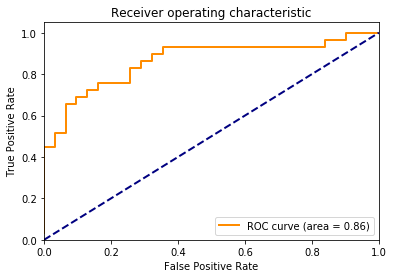

Accuracy: 0.783333333333
Specificity: 0.806451612903
Sensitivity: 0.758620689655


In [10]:
from performance_measures import *

y_prob = model.predict(data["X_test"])
y_pred = np.argmax(y_prob,axis=1)
y_true = data["y_test"]

AUC = get_roc_auc(y_true,y_prob[:,1])
accuracy = score[1]

#True Negative Rate 0,0
specificity = get_specificity(y_true,y_pred)
#True Positive Rate 1,1
sensitivity = get_sensitivity(y_true,y_pred)

print("Accuracy:",accuracy)
print("Specificity:",specificity)
print("Sensitivity:",sensitivity)

# Examples of Data Augmentations

##### The Network is trained using images from Aarhus University. The examples below were sourced using Google Image search and are just to demonstrate the data augmentations

In [11]:
%matplotlib inline
files = []
for file_path in glob.iglob('**/*.jpg', recursive=True):
    files.append(file_path)
    
X = []
y = []
for file in files:
    patient = str(file).split("/")[-1]
    patient_type = str(file).split("/")[1]
    img = resize(imread(file),(299,299,3),mode="constant")
    #print(img.shape)
    X.append(img)
    if(patient_type == "vulgaris"):
        y.append(0)
    else:
        y.append(1)

X = np.asarray(X)
y = np.asarray(y)

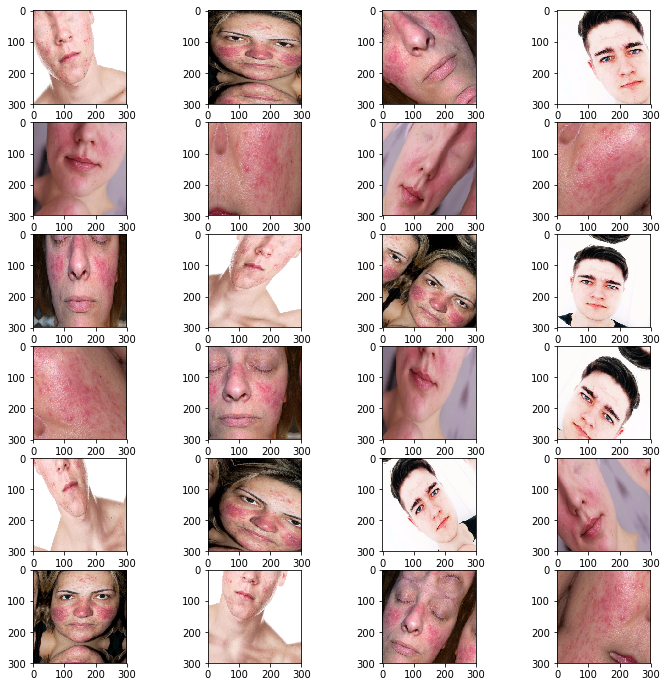

In [12]:
i = 0
columns = 4
plt.figure(figsize=(12,12))
for batch in train_gen.flow(X, y, batch_size=len(X)):
    for k, im in enumerate(batch[0]):
        if i > (len(X)*columns)-1:
            break
        plt.subplot(len(X), columns, i+1)
        plt.imshow(im)
        i += 1
    if i > (len(X)*columns)-1:
            break

# Save the model

In [13]:
model.save('augment.h5') 